import section

In [1]:
import pandas as pd
from pandas import DataFrame
import ast
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Load the sales data
sales_df = pd.read_csv('data/sale.csv', sep=',')

# Load the menu data
menu_df = pd.read_csv('data/menus.csv', sep=',')

# Load the add-on data
add_on_df = pd.read_csv('data/add-on.csv', sep=',')

# Check basic info of each dataframe
menu_df.info(), sales_df.info(), add_on_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         48 non-null     object 
 1   name         48 non-null     object 
 2   category     48 non-null     object 
 3   price        48 non-null     float64
 4   description  48 non-null     object 
 5   cost         48 non-null     float64
dtypes: float64(2), object(4)
memory usage: 2.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108000 entries, 0 to 107999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   uuid       108000 non-null  object
 1   date_time  108000 non-null  object
 2   menu_item  108000 non-null  object
 3   add_ons    108000 non-null  object
dtypes: object(4)
memory usage: 3.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column  Non-N

(None, None, None)

Additional function

In [3]:
# Function to calculate the total price of add-ons
def calculate_addon_price(addons, addons_df: DataFrame) -> float:
    addons_list = ast.literal_eval(addons)  # Convert the string representation of list to actual list
    total_price = 0
    for addon in addons_list:
        price = addons_df.loc[addons_df['name'] == addon, 'price']
        if not price.empty:
            total_price += price.values[0]
    return total_price

Preparation section

In [4]:
# Preprocess menu_df
menu_df['price'] = menu_df['price'].astype(float)  # Ensure price is of type float
menu_df = menu_df.drop(columns=['uuid', 'description'])  # Drop unnecessary columns
menu_df = menu_df.rename(columns={'name': 'menu_name'})  # Rename column for consistency
menu_df = menu_df.dropna(axis=0, how='any')  # Drop rows with any NaN values
menu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   menu_name  48 non-null     object 
 1   category   48 non-null     object 
 2   price      48 non-null     float64
 3   cost       48 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.6+ KB


In [5]:
# Preprocess sales_df
sales_df = sales_df.drop(columns=['uuid'])  # Drop unnecessary columns
sales_df = sales_df.rename(columns={'menu_item': 'menu_name'})  # Rename column for consistency
sales_df = sales_df.sort_values('date_time', ascending=True).reset_index(drop=True)  # Sort by date_time and reset index
sales_df = sales_df.dropna(axis=0, how='any')  # Drop rows with any NaN values
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108000 entries, 0 to 107999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date_time  108000 non-null  object
 1   menu_name  108000 non-null  object
 2   add_ons    108000 non-null  object
dtypes: object(3)
memory usage: 2.5+ MB


In [6]:
# Preprocess add_on_df
add_on_df = add_on_df.drop(columns=['uuid'])  # Drop unnecessary columns
add_on_df = add_on_df.dropna(axis=0, how='any')  # Drop rows with any NaN values
add_on_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   menu    46 non-null     object 
 1   name    46 non-null     object 
 2   price   46 non-null     float64
 3   cost    46 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.6+ KB


In [7]:
# Merge dataframes
merged_df = pd.merge(menu_df, sales_df, on='menu_name', how='inner')  # Merge menu and sales data on menu_name
merged_df = merged_df.dropna(axis=0, how='any')  # Drop rows with any NaN values
merged_df["date_time"] = pd.to_datetime(merged_df["date_time"])  # Convert date_time to datetime format
merged_df = merged_df.sort_values(by='date_time', ascending=True).reset_index(
    drop=True)  # Sort by date_time and reset index
merged_df["date"] = merged_df["date_time"].dt.strftime("%Y-%m-%d")  # Extract date
merged_df["time"] = merged_df["date_time"].dt.strftime("%H:%M")  # Extract time
# merged_df = merged_df.drop(columns=["date_time"])  # Drop the original date_time column
merged_df["add_ons_price"] = merged_df["add_ons"].apply(
    lambda x: calculate_addon_price(x, add_on_df))  # Calculate add_ons_price
merged_df["total_price"] = merged_df["add_ons_price"] + merged_df["price"]  # Calculate total price
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108000 entries, 0 to 107999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   menu_name      108000 non-null  object        
 1   category       108000 non-null  object        
 2   price          108000 non-null  float64       
 3   cost           108000 non-null  float64       
 4   date_time      108000 non-null  datetime64[ns]
 5   add_ons        108000 non-null  object        
 6   date           108000 non-null  object        
 7   time           108000 non-null  object        
 8   add_ons_price  108000 non-null  float64       
 9   total_price    108000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 8.2+ MB


In [8]:
# Check for missing values
missing_values = merged_df.isnull().sum()
print(missing_values)

menu_name        0
category         0
price            0
cost             0
date_time        0
add_ons          0
date             0
time             0
add_ons_price    0
total_price      0
dtype: int64


In [9]:
# Display the first few rows of the final merged dataframe
merged_df.head(20)

,menu_name,category,price,cost,date_time,add_ons,date,time,add_ons_price,total_price
0,Tim Tam Cheesecake,"CAKES, SLICES & SWEETS",12.0,10.62,2021-07-25 08:04:19.993417,[],2021-07-25,08:04,0.0,12.0
1,Pavlova,"CAKES, SLICES & SWEETS",20.0,18.90,2021-07-25 08:20:19.993417,[],2021-07-25,08:20,0.0,20.0
2,Savoury muffin,House Made Pastries,6.0,5.31,2021-07-25 08:31:19.993417,[],2021-07-25,08:31,0.0,6.0
3,"Chicken, avocado, lettuce & aioli",Toasties On Sourdough,11.5,11.29,2021-07-25 08:33:19.993417,[],2021-07-25,08:33,0.0,11.5
4,BURRITO BOWL,All day lunch,18.5,18.19,2021-07-25 08:36:19.993417,[],2021-07-25,08:36,0.0,18.5
5,"Ham, cheese & tomato",Toasties On Sourdough,7.5,7.36,2021-07-25 08:40:19.993417,[],2021-07-25,08:40,0.0,7.5
6,COCONUT & CHIA PUDDING,All day breakfast,17.5,16.20,2021-07-25 08:46:19.993417,[],2021-07-25,08:46,0.0,17.5
7,Avocado & cheese,Toasties On Sourdough,9.0,8.30,2021-07-25 08:48:19.993417,[],2021-07-25,08:48,0.0,9.0
8,Fairy Bread,"CAKES, SLICES & SWEETS",26.0,25.79,2021-07-25 08:52:19.993417,[],2021-07-25,08:52,0.0,26.0
9,Apple Juice,Beverage,5.0,4.12,2021-07-25 08:53:19.993417,['Ice'],2021-07-25,08:53,0.0,5.0


**Analysis section**

---

In [10]:
# Analyze merged_df for negative prices
negative_price = merged_df[merged_df['price'] < 0]
negative_add_ons_price = merged_df[merged_df['add_ons_price'] < 0]
negative_total_price = merged_df[merged_df['total_price'] < 0]

# Display dataframes with negative values
print(negative_price)
print(negative_add_ons_price)
print(negative_total_price)

Empty DataFrame
Columns: [menu_name, category, price, cost, date_time, add_ons, date, time, add_ons_price, total_price]
Index: []
Empty DataFrame
Columns: [menu_name, category, price, cost, date_time, add_ons, date, time, add_ons_price, total_price]
Index: []
Empty DataFrame
Columns: [menu_name, category, price, cost, date_time, add_ons, date, time, add_ons_price, total_price]
Index: []


In [11]:
# Display first few rows and summary statistics of add_on_df
add_on_df.head()

,menu,name,price,cost
0,Sparkling Water,Ice,0.0,1.24
1,Sparkling Water,Lemon Slice,0.5,0.58
2,Sparkling Water,Lime Slice,0.5,0.65
3,Cola,Ice,0.0,0.48
4,Cola,Lemon Slice,0.5,0.32


In [12]:
add_on_df.describe()

,price,cost
count,46.000000,46.000000
mean,1.380435,1.236739
std,1.539065,1.194376
min,0.000000,0.010000
25%,0.500000,0.320000
50%,0.500000,0.805000
75%,2.500000,1.435000
max,4.500000,4.050000


In [13]:
# Count occurrences of each menu in add_on_df
menu_counts = add_on_df['menu']
menu_counts.value_counts()

menu
EGGS ON TOAST                  6
Hot Chocolate                  4
Mocha                          4
AVOCADO TOAST                  4
Cappuccino                     4
Latte                          4
Flat White                     4
Sparkling Water                3
NEW YORK BAGEL BENEDICT        3
Lemonade                       2
Cola                           2
BURRITO BOWL                   1
Long Black                     1
Espresso                       1
Orange Juice                   1
Apple Juice                    1
HUEVOS (SPANISH BAKED EGGS)    1
Name: count, dtype: int64

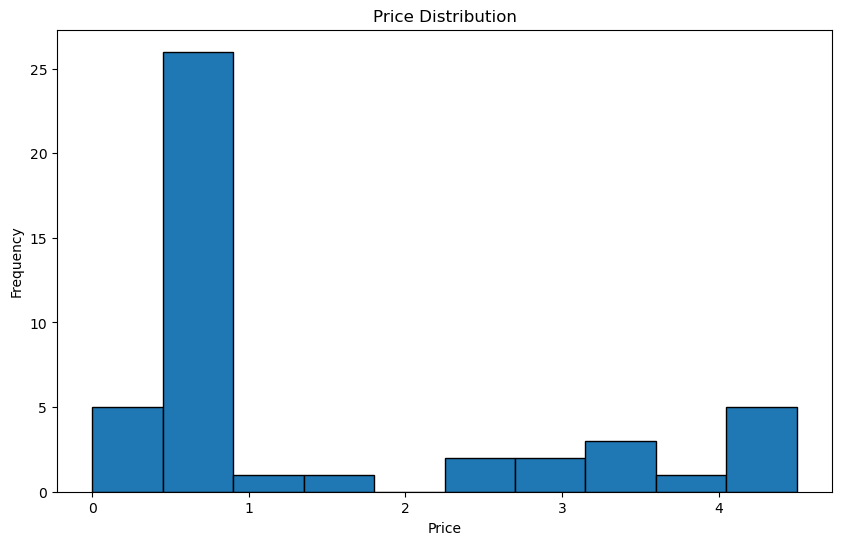

In [14]:
# Plot the distribution of add-on prices
plt.figure(figsize=(10, 6))
plt.hist(add_on_df['price'], bins=10, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

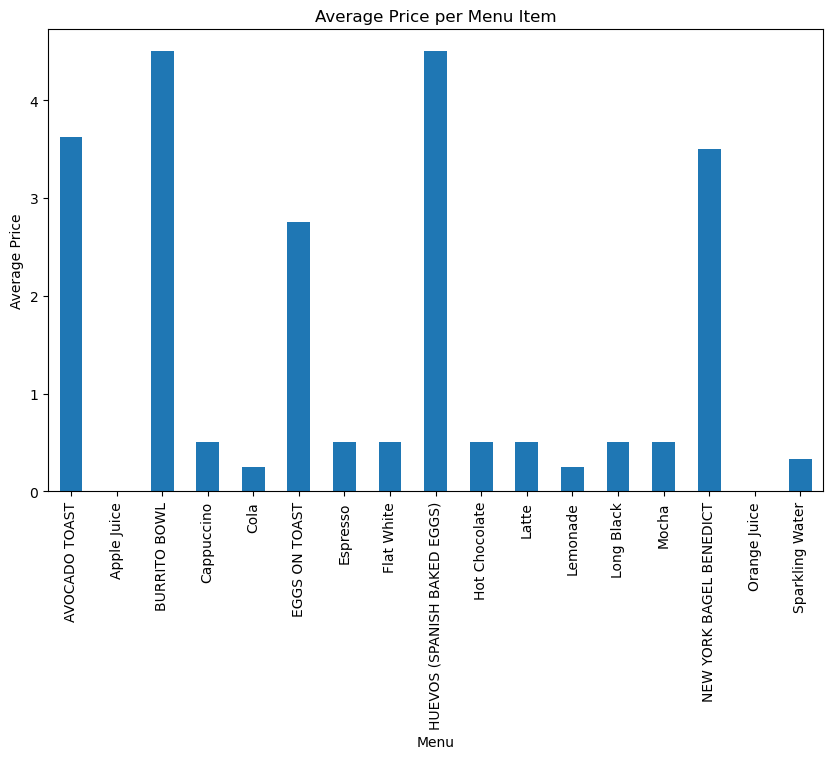

In [15]:
# Calculate and plot average price per menu item in add_on_df
average_price_per_menu = add_on_df.groupby('menu')['price'].mean()
plt.figure(figsize=(10, 6))
average_price_per_menu.plot(kind='bar')
plt.title('Average Price per Menu Item')
plt.xlabel('Menu')
plt.ylabel('Average Price')
plt.show()

In [16]:
# Add day of the week to merged_df
merged_df['date'] = pd.to_datetime(merged_df['date'])  # Ensure 'date' is in datetime format
merged_df['day_of_week'] = merged_df['date'].dt.day_name()  # Extract day of the week

In [17]:
merged_df.head()

,menu_name,category,price,cost,date_time,add_ons,date,time,add_ons_price,total_price,day_of_week
0,Tim Tam Cheesecake,"CAKES, SLICES & SWEETS",12.0,10.62,2021-07-25 08:04:19.993417,[],2021-07-25,08:04,0.0,12.0,Sunday
1,Pavlova,"CAKES, SLICES & SWEETS",20.0,18.90,2021-07-25 08:20:19.993417,[],2021-07-25,08:20,0.0,20.0,Sunday
2,Savoury muffin,House Made Pastries,6.0,5.31,2021-07-25 08:31:19.993417,[],2021-07-25,08:31,0.0,6.0,Sunday
3,"Chicken, avocado, lettuce & aioli",Toasties On Sourdough,11.5,11.29,2021-07-25 08:33:19.993417,[],2021-07-25,08:33,0.0,11.5,Sunday
4,BURRITO BOWL,All day lunch,18.5,18.19,2021-07-25 08:36:19.993417,[],2021-07-25,08:36,0.0,18.5,Sunday


In [18]:
merged_df.describe()

,price,cost,date_time,date,add_ons_price,total_price
count,108000.000000,108000.00000,108000,108000,108000.000000,108000.000000
mean,9.685278,8.72767,2023-01-16 08:59:29.170083840,2023-01-15 21:50:57.600000256,0.176968,9.862245
min,3.000000,1.45000,2021-07-25 08:04:19.993417,2021-07-25 00:00:00,0.000000,3.000000
25%,4.500000,3.60000,2022-04-21 09:25:34.993416960,2022-04-21 00:00:00,0.000000,4.500000
50%,7.000000,6.33000,2023-01-15 10:41:19.993416960,2023-01-15 00:00:00,0.000000,7.000000
75%,16.000000,15.71000,2023-10-14 10:23:34.993416960,2023-10-14 00:00:00,0.000000,16.500000
max,26.000000,25.79000,2024-07-07 14:48:19.993417,2024-07-07 00:00:00,16.500000,30.500000
std,6.364053,6.45176,NaN,NaN,1.069974,6.481643


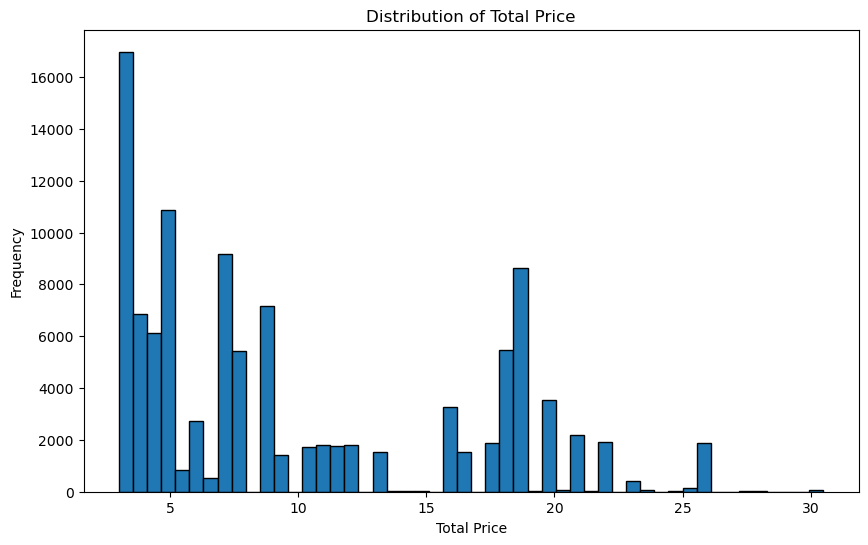

In [19]:
# Plot the distribution of total prices in merged_df
plt.figure(figsize=(10, 6))
plt.hist(merged_df['total_price'], bins=50, edgecolor='black')
plt.xlabel('Total Price')
plt.ylabel('Frequency')
plt.title('Distribution of Total Price')
plt.show()

In [20]:
# Perform ANOVA to test for significant differences in total_price between categories
categories = merged_df['category'].unique()
data = [merged_df[merged_df['category'] == category]['total_price'] for category in categories]
f_val, p_val = stats.f_oneway(*data)
print(f'ANOVA results: F-value = {f_val}, P-value = {p_val}')

ANOVA results: F-value = 91186.84794296903, P-value = 0.0


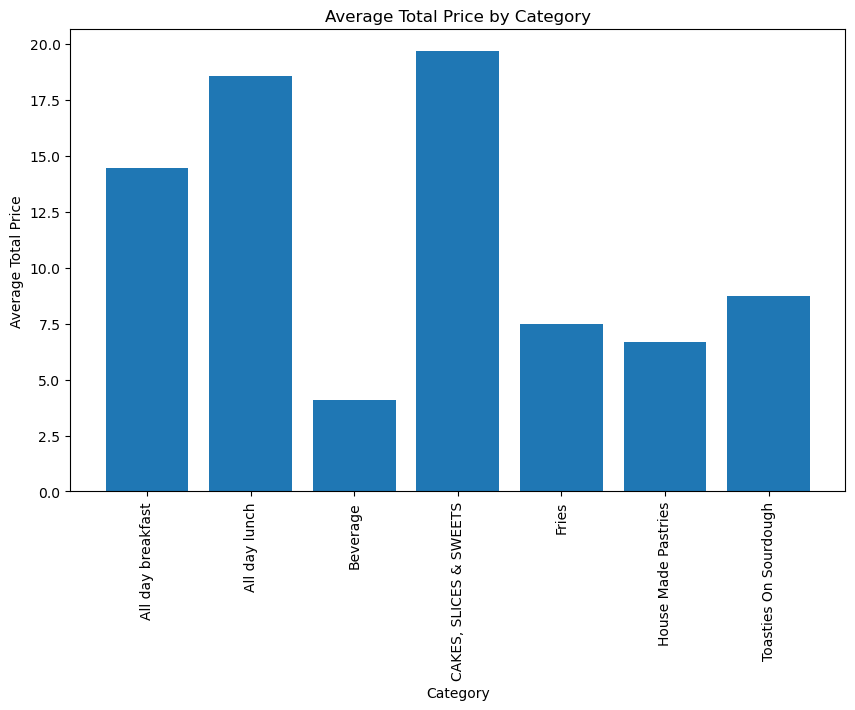

In [21]:
 # Calculate and plot average total price by category
avg_price_by_category = merged_df.groupby('category')['total_price'].mean()
plt.figure(figsize=(10, 6))
plt.bar(avg_price_by_category.index, avg_price_by_category.values)
plt.xlabel('Category')
plt.ylabel('Average Total Price')
plt.title('Average Total Price by Category')
plt.xticks(rotation=90)
plt.show()

# analyze sale

In [22]:
sale_analyze_df = merged_df

In [23]:
sale_analyze_df.head()

,menu_name,category,price,cost,date_time,add_ons,date,time,add_ons_price,total_price,day_of_week
0,Tim Tam Cheesecake,"CAKES, SLICES & SWEETS",12.0,10.62,2021-07-25 08:04:19.993417,[],2021-07-25,08:04,0.0,12.0,Sunday
1,Pavlova,"CAKES, SLICES & SWEETS",20.0,18.90,2021-07-25 08:20:19.993417,[],2021-07-25,08:20,0.0,20.0,Sunday
2,Savoury muffin,House Made Pastries,6.0,5.31,2021-07-25 08:31:19.993417,[],2021-07-25,08:31,0.0,6.0,Sunday
3,"Chicken, avocado, lettuce & aioli",Toasties On Sourdough,11.5,11.29,2021-07-25 08:33:19.993417,[],2021-07-25,08:33,0.0,11.5,Sunday
4,BURRITO BOWL,All day lunch,18.5,18.19,2021-07-25 08:36:19.993417,[],2021-07-25,08:36,0.0,18.5,Sunday


In [26]:
# Calculate sales for each item
sale_analyze_df['sales'] = sale_analyze_df['price'] * sale_analyze_df.groupby('menu_name')['menu_name'].transform(
    'count')

# Total sales
total_sales = sale_analyze_df['sales'].sum()
print(f'Total estimated sales: ${total_sales:.2f}')

Total estimated sales: $2190309010.00


In [27]:
# Define time categories
def categorize_time(hour):
    if 6 <= hour < 11:
        return 'Breakfast'
    elif 11 <= hour < 14:
        return 'Lunch'
    elif 14 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Dinner'
    else:
        return 'Other'

In [28]:
# Function to plot bars for aggregated data
def plot_bars(agg_data, title, x_label, y_label):
    agg_data.plot(kind='bar', figsize=(12, 6))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [29]:
# Extract year, month, and day from date
sale_analyze_df['year'] = sale_analyze_df['date_time'].dt.year
sale_analyze_df['month'] = sale_analyze_df['date_time'].dt.month
sale_analyze_df['day'] = sale_analyze_df['date_time'].dt.day
sale_analyze_df['hour'] = sale_analyze_df['date_time'].dt.hour

# Calculate total sales, total cost, and total sale difference (sales - cost) for all data
total_sales_all = sale_analyze_df['price'].sum()
total_cost_all = sale_analyze_df['cost'].sum()
total_sale_difference_all = total_sales_all - total_cost_all

# Calculate total sales, total cost, and sale difference (sales - cost)
sale_analyze_df['total_sales'] = sale_analyze_df.groupby(['year', 'month', 'day'])['price'].transform('sum')
sale_analyze_df['total_cost'] = sale_analyze_df.groupby(['year', 'month', 'day'])['cost'].transform('sum')
sale_analyze_df['total_sale_difference'] = sale_analyze_df['total_sales'] - sale_analyze_df['total_cost']
sale_analyze_df['sale_difference'] = sale_analyze_df['price'] - sale_analyze_df['cost']

sale_analyze_df['time_category'] = sale_analyze_df['hour'].apply(categorize_time)

# Calculate sales and sale difference
sale_analyze_df['sales'] = sale_analyze_df['price']
sale_analyze_df['sale_difference'] = sale_analyze_df['sales'] - sale_analyze_df['cost']

In [30]:
# Aggregate by day of week
agg_day_of_week = sale_analyze_df.groupby('day_of_week').agg({
    'sales': 'sum',
    'cost': 'sum',
    'sale_difference': 'sum'
}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Aggregate by time category
agg_time_category = sale_analyze_df.groupby('time_category').agg({
    'sales': 'sum',
    'cost': 'sum',
    'sale_difference': 'sum'
})

# Aggregate by year, month, day (as previously described)
agg_year = sale_analyze_df.groupby('year').agg({
    'sales': 'sum',
    'cost': 'sum',
    'sale_difference': 'sum'
}).reset_index()

agg_month = sale_analyze_df.groupby(['year', 'month']).agg({
    'sales': 'sum',
    'cost': 'sum',
    'sale_difference': 'sum'
}).reset_index()

agg_month_avg = sale_analyze_df.groupby('month').agg({
    'sales': 'mean',
    'cost': 'mean',
    'sale_difference': 'mean'
}).reset_index()

agg_day = sale_analyze_df.groupby(['year', 'month', 'day']).agg({
    'sales': 'sum',
    'cost': 'sum',
    'sale_difference': 'sum'
}).reset_index()

agg_day_avg = sale_analyze_df.groupby(['month', 'day']).agg({
    'sales': 'mean',
    'cost': 'mean',
    'sale_difference': 'mean'
}).reset_index()

# Plot total sales, cost, and sale difference for all data
total_sales_all = sale_analyze_df['sales'].sum()
total_cost_all = sale_analyze_df['cost'].sum()
total_sale_difference_all = total_sales_all - total_cost_all


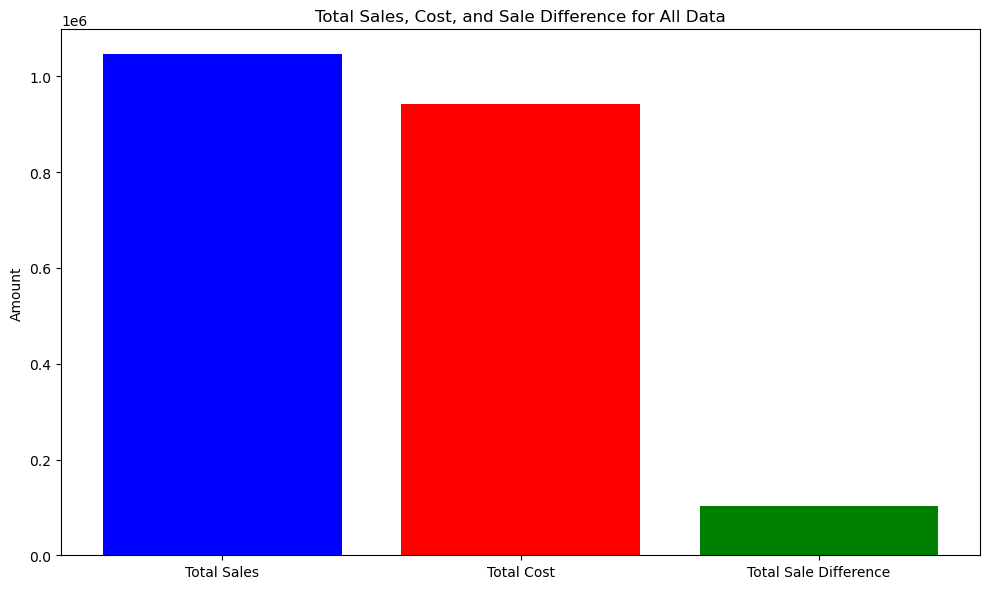

In [31]:
plt.figure(figsize=(10, 6))
labels = ['Total Sales', 'Total Cost', 'Total Sale Difference']
values = [total_sales_all, total_cost_all, total_sale_difference_all]
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.title('Total Sales, Cost, and Sale Difference for All Data')
plt.ylabel('Amount')
plt.tight_layout()
plt.show()

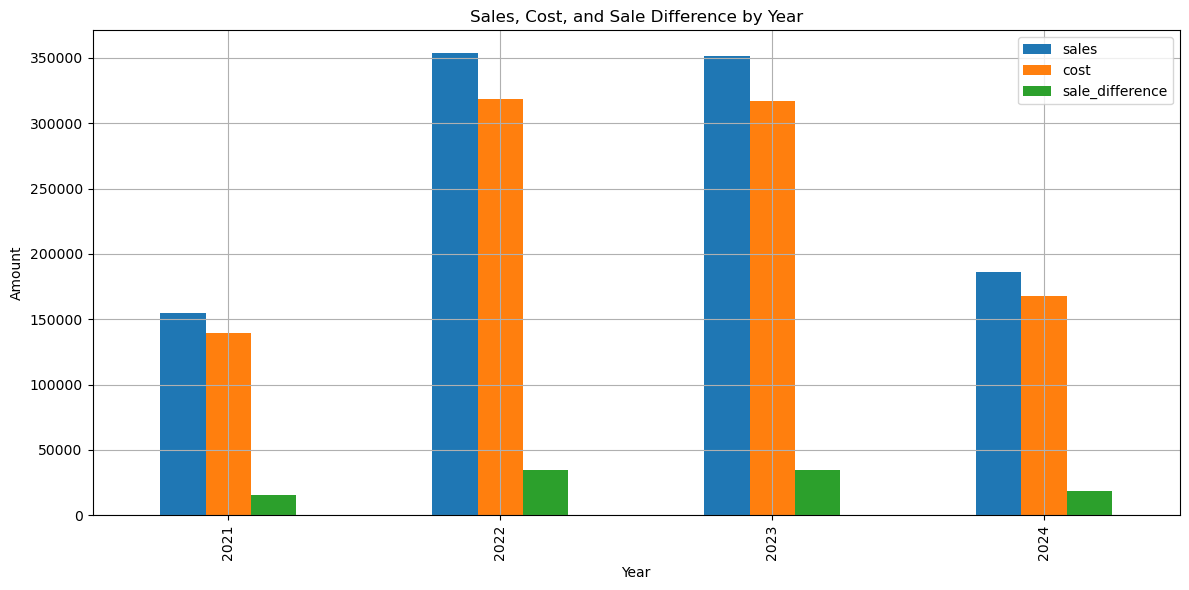

In [32]:
# Plot sales, cost, and sale difference by year
plot_bars(agg_year.set_index('year'), 'Sales, Cost, and Sale Difference by Year', 'Year', 'Amount')

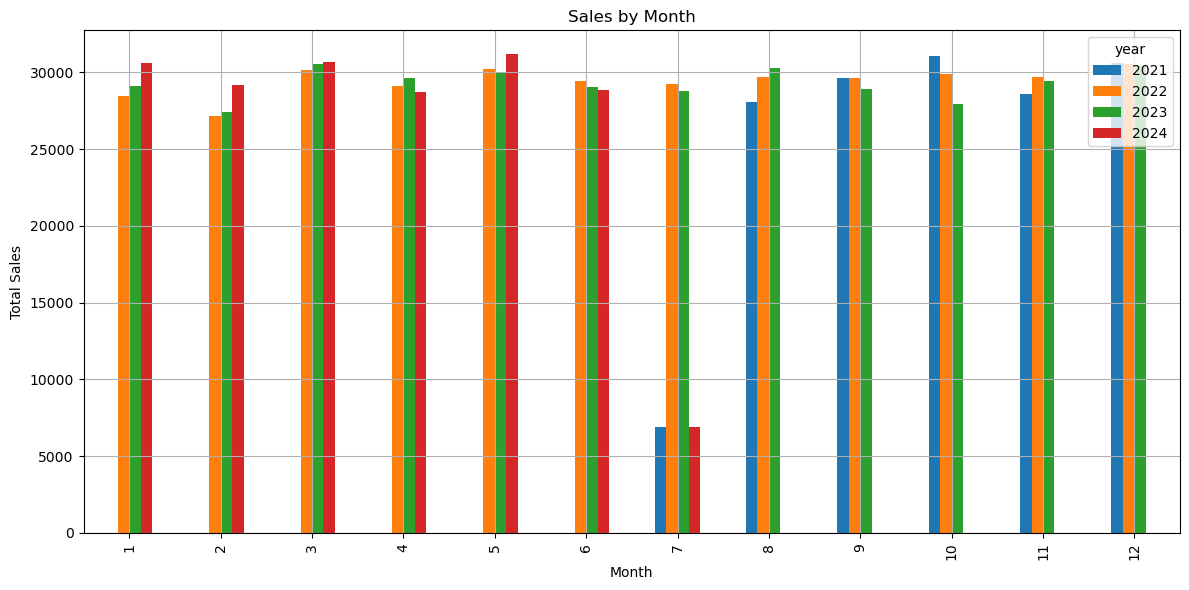

In [33]:
# Plot sales, cost, and sale difference by month (total in each month)
plot_bars(agg_month.pivot(index='month', columns='year', values='sales'), 'Sales by Month', 'Month', 'Total Sales')

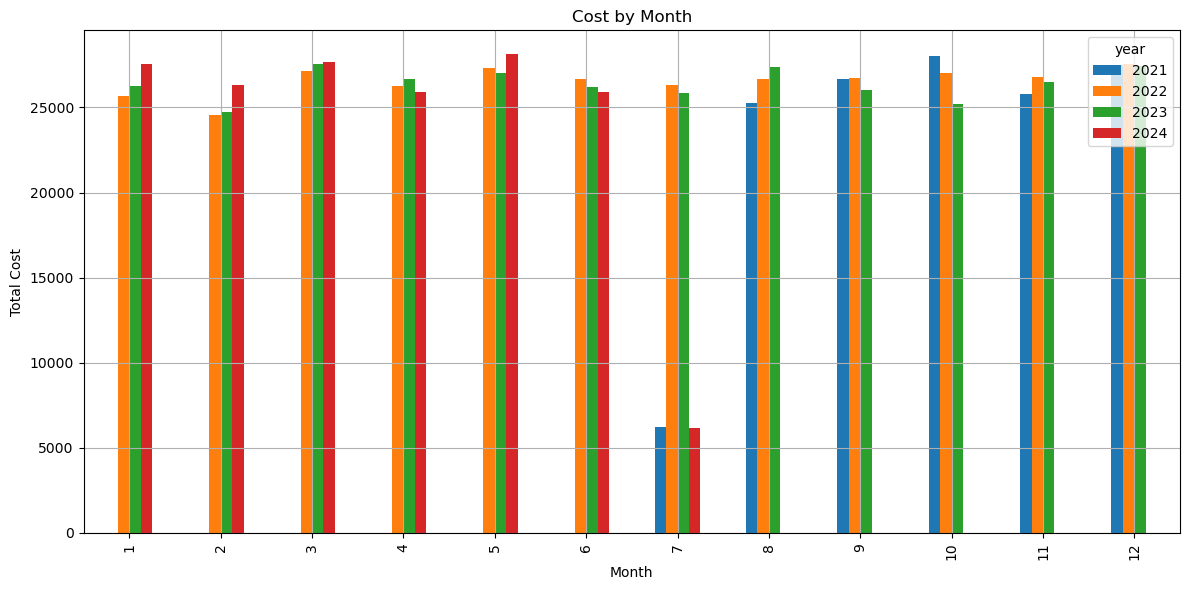

In [34]:
plot_bars(agg_month.pivot(index='month', columns='year', values='cost'), 'Cost by Month', 'Month', 'Total Cost')

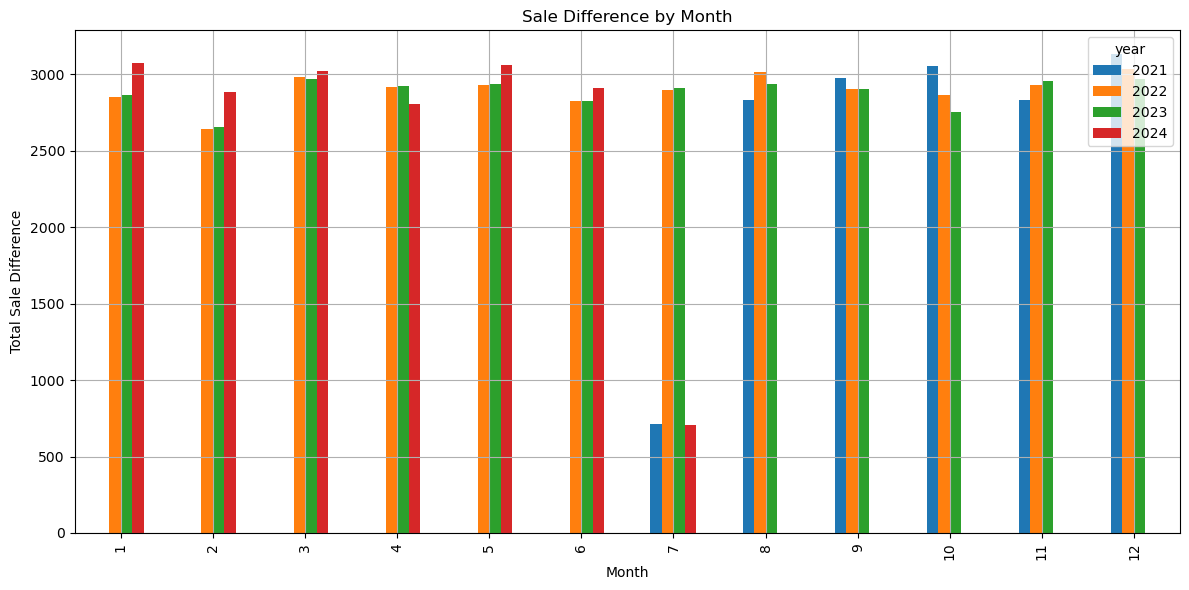

In [35]:
plot_bars(agg_month.pivot(index='month', columns='year', values='sale_difference'), 'Sale Difference by Month', 'Month', 'Total Sale Difference')

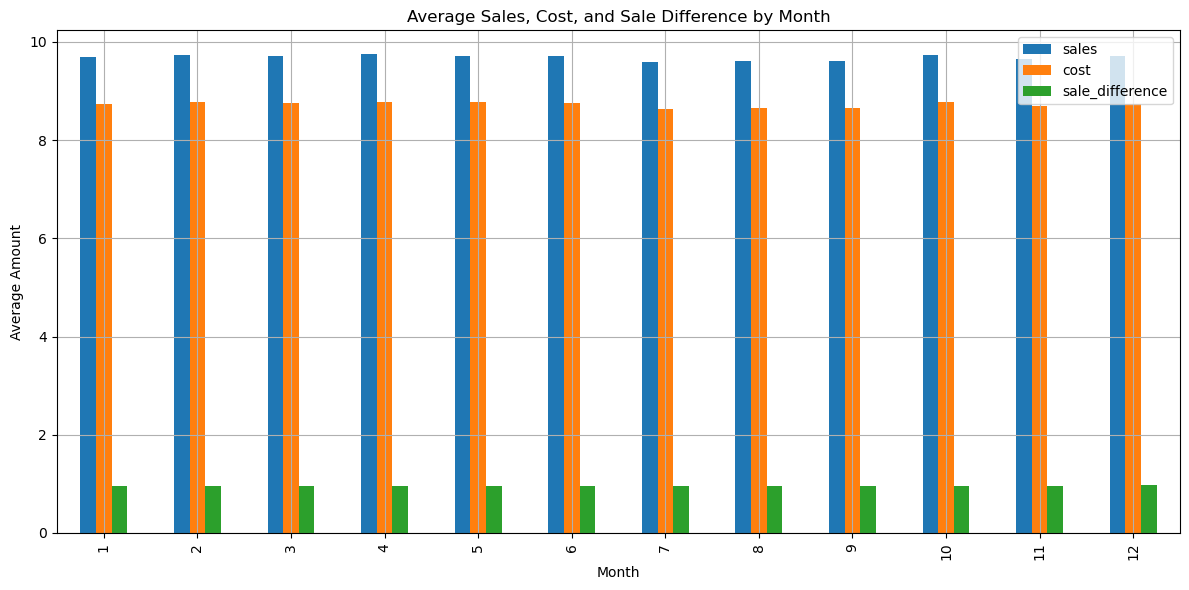

In [36]:
# Plot average sales, cost, and sale difference by month
plot_bars(agg_month_avg.set_index('month'), 'Average Sales, Cost, and Sale Difference by Month', 'Month', 'Average Amount')

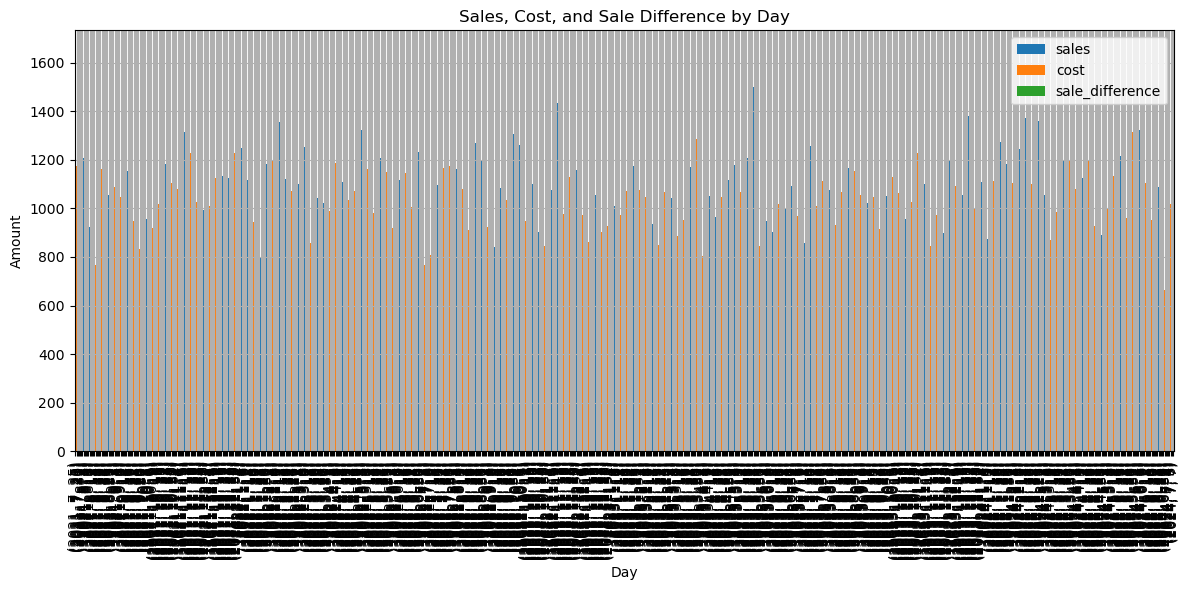

In [37]:

# Plot sales, cost, and sale difference by day (total in each day)
plot_bars(agg_day.set_index(['year', 'month', 'day']), 'Sales, Cost, and Sale Difference by Day', 'Day', 'Amount')

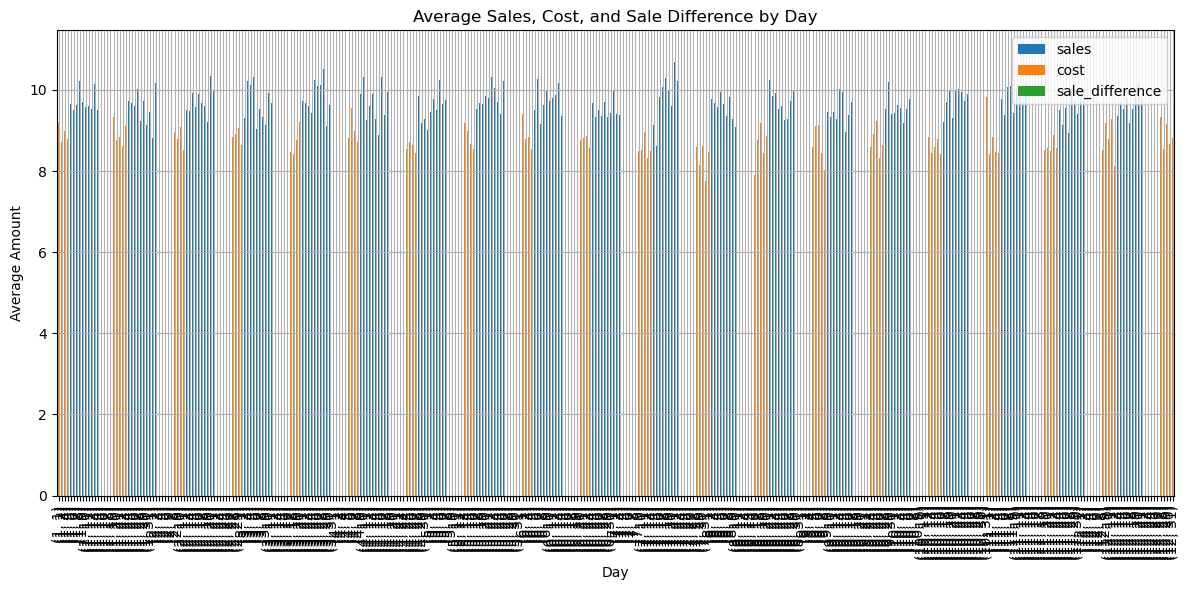

In [38]:
# Plot average sales, cost, and sale difference by day
plot_bars(agg_day_avg.set_index(['month', 'day']), 'Average Sales, Cost, and Sale Difference by Day', 'Day', 'Average Amount')

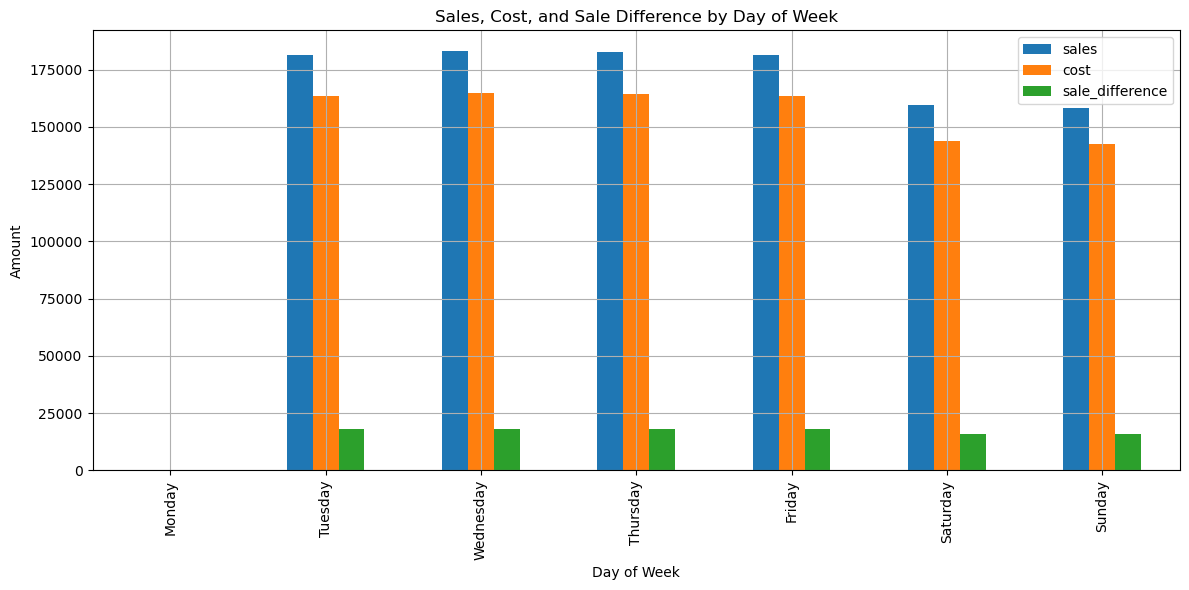

In [39]:
# Plot sales, cost, and sale difference by day of week
plot_bars(agg_day_of_week, 'Sales, Cost, and Sale Difference by Day of Week', 'Day of Week', 'Amount')

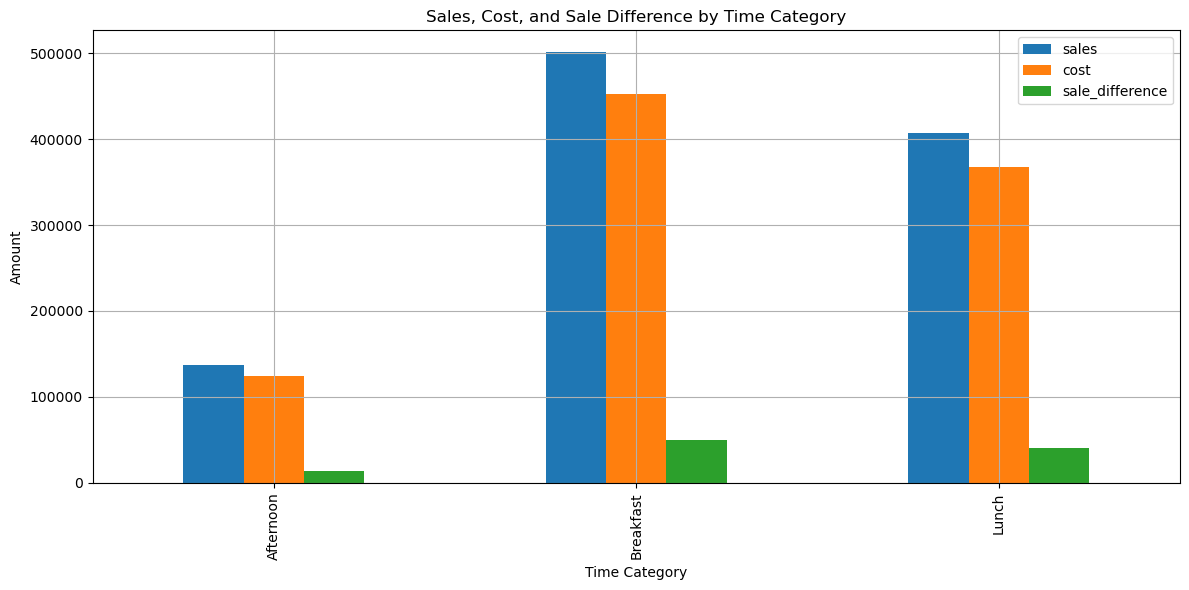

In [40]:
# Plot sales, cost, and sale difference by time category
plot_bars(agg_time_category, 'Sales, Cost, and Sale Difference by Time Category', 'Time Category', 'Amount')

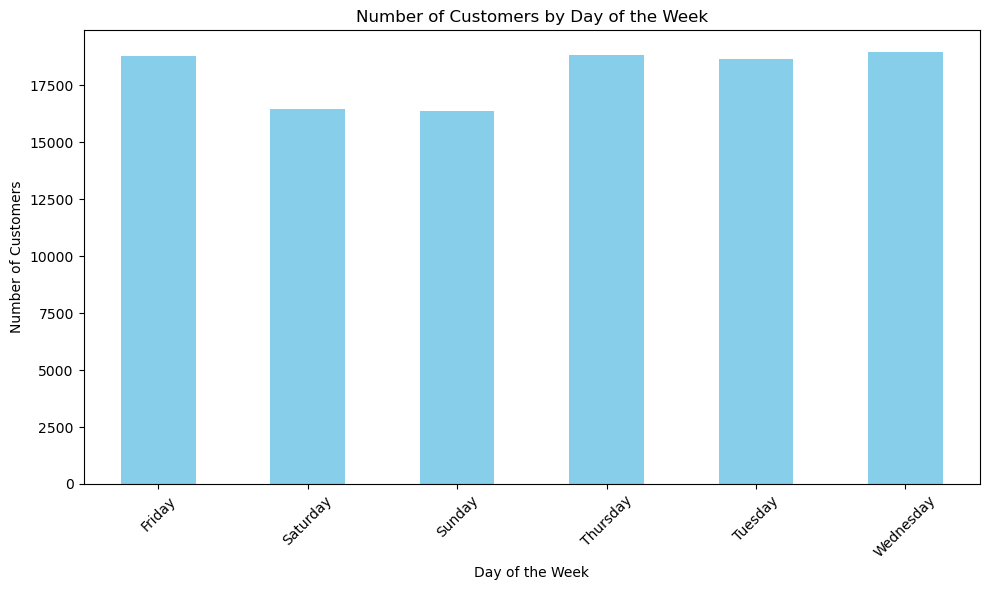

In [41]:
# Count number of customers per day of the week
daily_customers = sale_analyze_df.groupby('day_of_week').size()

plt.figure(figsize=(10, 6))
daily_customers.plot(kind='bar', color='skyblue')
plt.title('Number of Customers by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\todalab\AppData\Local\Temp\ipykernel_6636\3494909084.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_customers = sale_analyze_df.groupby('time_category').size()


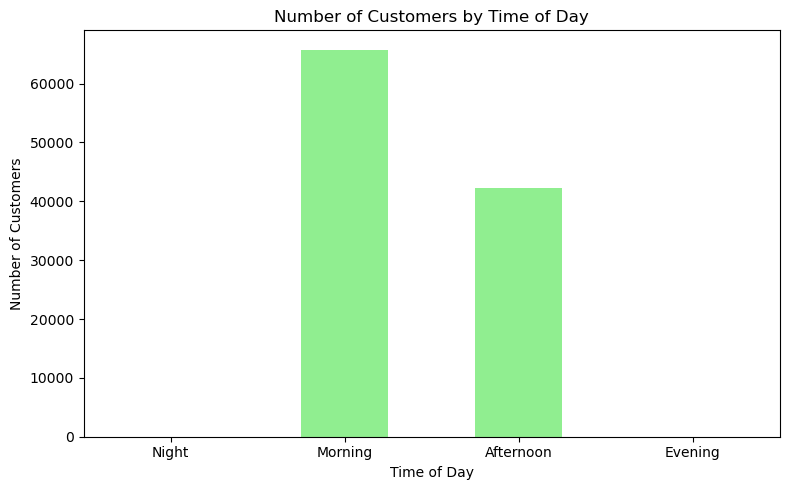

In [42]:
# Optional: Create time categories (e.g., breakfast, lunch, dinner)
# Define time intervals for categorization
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
sale_analyze_df['time_category'] = pd.cut(sale_analyze_df['date_time'].dt.hour, bins=bins, labels=labels, right=False)

# Count number of customers by time category
time_customers = sale_analyze_df.groupby('time_category').size()

# Plotting number of customers by time category
plt.figure(figsize=(8, 5))
time_customers.plot(kind='bar', color='lightgreen')
plt.title('Number of Customers by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()